# HCI Week 2 - The disk around Beta Pictoris
*Matthew Kenworthy // Leiden Observatory*


You will analyse coronagraphic data of Beta Pictoris and investigate which one of three methods gives the clearest signal for the disk.


Two images were taken - one of beta Pic and one of a nearby reference star aligned behind the coronagraph. *Data reproduced here by kind permission of Paul Kalas. Observation date 10 October 1993. PSF reference star is HR 919.*

**REMEMBER** that coordinates in `numpy` arrays are transposed, so that point $(x,y)$ is at `[y,x]`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def zoom(im,x,y,bb):
    '''returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def rotate2(img, angle, c_in):
    '''rotate input image img by angle degrees about a point c_in
    c_in is an np.array((y,x))
    returns the rotated image with zeroes for unknown values'''
    from scipy.ndimage.interpolation import affine_transform
    # convert angle from degrees to radians
    a=angle*np.pi/180.0
    # build a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    # work out the offset in pixels for the output image
    offset=c_in-c_in.dot(transform)
    # pass all these values into the affine transform that includes rotation and translation
    dst=affine_transform(img,transform.T,order=2,offset=offset,output_shape=(img.shape),cval=0.0)
    return(dst)


Open the images in `ds9` and determine the location of beta Pictoris and write down the coordinates in two new `numpy` variables `xcen` and `ycen`.

**SUPER IMPORTANT NOTE:** `ds9` coordinate starts with the lower left pixel at `(1,1)` but the Python numpy system starts from `(0,0)`! Remember this 'off by one' error when using coordinates from `ds9` in Python....

**Q1 (2 points):** Show that you have the right location for the star by displaying the image with a square box of 40 pixels width centered on the star. (Hint: look at the functions defined in the cell above).



In [2]:
# loading in the images into the Notebook.

pic1, pic1_header = fits.getdata("pics/pic1.fits", header=True)
ref1, ref1_header = fits.getdata("pics/hr9.1.fits", header=True)

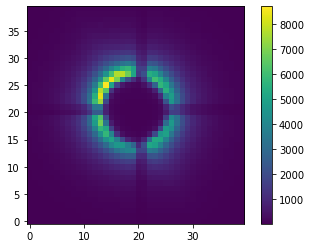

In [3]:
# visually determine the center of beta pic by examining the image in DS9

xcen,ycen = 263-1,197-1 #for pic1.fits and hr9

image = zoom(pic1,xcen,ycen,20)


# Q1 answer here
plt.imshow(image)
plt.colorbar()
# END Q1 answer


**Q2 (4 points):** Select a sky background region of 50 by 50 pixels that has no pixel or camera defects or stars in it. Display the region using `imshow()`. Determine the background mean and r.m.s. of the image by using `np.mean()` and `np.std()`. Print out both values to 2 significant figures using the `print()` command and the Pythonic [formatters detailed on this page](https://www.python-course.eu/python3_formatted_output.php).

Mean = -0.004
Standard Deviation = 0.266


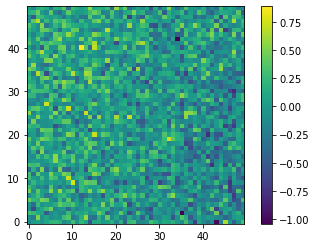

In [4]:
# Q2 answer here
#Background coordinates
xref,yref = 122-1,230-1
#name variable
background = zoom(pic1,xref,yref,25)

#Display
plt.imshow(background)
plt.colorbar()

print("Mean = %.3f" % np.mean(background))
print("Standard Deviation = %.3f" % np.std(background))


## Method 1: Unsharp masking with a Top Hat Kernel

Read the `astropy` documents on [convolution](http://astropy.readthedocs.org/en/latest/convolution/) and [kernels](http://astropy.readthedocs.org/en/latest/convolution/kernels.html). 

**Q3 (5 points):** Using the `circle_mask()` routine you wrote last week, make a square image 11 pixels on a side that contains a circle 11 pixels in diameter. Normalise the total flux in the image to 1. This will be your **Top Hat smoothing kernel**. (Note that you can also do this with `Tophat2DKernel` below). 

Convolve the Beta Pic image with this kernel to produce an image that only follows the low spatial frequencies. Subtract this smoothed image off of the original Beta Pic image, write it out to a `FITS` file, and look at it in `ds9`.



In [5]:
#Circle function from last week
def circ_in_array(im,xc,yc,r):
    '''
    #  Input:
    #       im:  2d array 
    #       xc:  x coordinate for circle center
    #       yc:  y coordinate for circle center
    #       r:   radius of circle
    #  Output:
    #       2d array with circle
    '''
    #Get the image coordinates
    y,x = im[0],im[1]
    #Make Image
    image = ((x-xc)**2 + (y-yc)**2 < r**2)
    return image

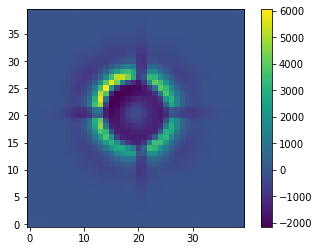

In [6]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel

# Q3 answer here
#Create TopHat mask
# im = np.mgrid[0:11,0:11]
# xc = im.max()/2
# th = circ_in_array(im,xc,xc,xc)
# # plt.imshow(th)
# th_norm = th / np.sum(th) #Normalize
# th_low_pass = convolve(pic1,th_norm)
# usm = pic1 - th_low_pass


# #Testing Tophat2DKernel
TH = Tophat2DKernel(5.5)
TH_low_pass = convolve(pic1,TH)
usm = pic1-TH_low_pass
'''
Both of these produce similar images, for simplicity's sake I'll leave the code as is
'''

plt.imshow(zoom(usm,xcen,ycen,20))
# plt.imshow(usm)
plt.colorbar()
'''
Looking at the new image in ds9, there doesn't appear to be much at first.  But if I change the scale histogram at min/max
There are a few artifacts that appear.  Whether or not they are exoplanets remains to be seen.  Doubtful though
'''
# END Q3 answer above

filename = 'usm_tophat.fits'
hdu = fits.PrimaryHDU(usm)
hdu.writeto(filename, overwrite=True)


## Unsharp Masking with Gaussian Kernel
Now carry out the unsharp masking with the Gaussian Kernel in `Gaussian2DKernel()`. Try different values for the sigma of the convolution kernel from 5 to 0.5, writing out the unsharp masked image first and examining it with `ds9`. 

**Q4 (2 points):** What happens to the disk and the halo for different values of the Kernel width?

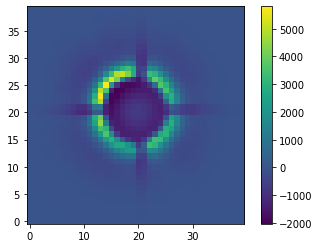

In [7]:
# write Q4 answer and smoothing for Kernel of 1.5 here

GaussK = Gaussian2DKernel(3,3)
Gauss_low_pass = convolve(pic1,GaussK)
usm2 = pic1 - Gauss_low_pass

plt.imshow(zoom(usm2,xcen,ycen,20))
plt.colorbar()


'''
5 sigma produces an image that appears to have fairly sharp contrast.
When I reduce the range, a central spot begins to appear behind the obscuration.  When you go down to a sigma of 0.5
There becomes almost no contrast between the light and the obscuration.  I will stick with 4 sigma to allow some dullness
in the contrast for the sake of the practium.
'''
# END Q4 answer

filename = 'usm_gaussian.fits'
hdu = fits.PrimaryHDU(usm2)
hdu.writeto(filename, overwrite=True)



## Method 2: Subtracting azimuthal averages
Here we take a set of concentric rings centered on beta Pic, calculate the mean value in each ring, and subtract it off the beta Pictoris image.

In the routine `r_theta` below, we generate an image with radial distance `r` and angle from the x-axis $\phi$ that we can use to make more masks.

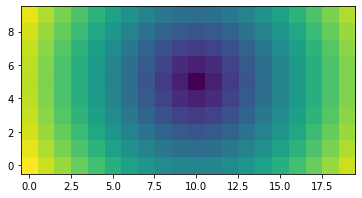

In [8]:

# make circular rings

def r_theta(im, xc, yc):
    '''make a radius mask'''
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

# show what it produces with a demonstration image

im1 = np.zeros((10,20))
r,t = r_theta(im1, 10,5)

plt.imshow(r)

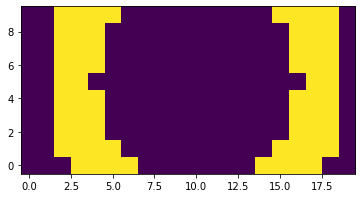

In [9]:
mask = (r > 6) * (r < 9)
plt.imshow(mask)

We can now make a routine that makes several concentric rings in one mask image, and can then use this as a mask for selecting successively larger rings in each image of Beta Pictoris. An example of the output is shown below. Look at the `for` loop in the routine, and look at how `enumerate()` generates index values in `i`.

**NOTE** there is a way to generate this image *without* using a `for` loop...

[ 5. 15. 25. 35. 45.]
5


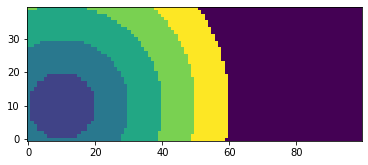

In [10]:
im2 = np.zeros((40,100))

def rings(im, x, y, r_rings):
    # makes a mask for rings of different radii specified in r_rings
    # and centre (x,y)
    # invalid values are -1
    # first, second, third... ring has value (0, 1, 2, ....)
    # ring 0 is from r_rings[0] to r_rings[1]
    # ring 1 is from r_rings[1] to r_rings[2]
    im_rings = np.zeros_like(im) - 1.
    
    # make r_inner and r_outer
    r_inner = r_rings[0:-1]
    r_outer = r_rings[1:]
    
    r, t = r_theta(im_rings, x, y)
    for i, (rin, rout) in enumerate(zip(r_inner,r_outer)):
        im_rings[(r >= rin) * (r < rout)] = i


    r_middle = (r_inner + r_outer) / 2.
    return(im_rings, r_middle)

r_rings = np.array([0,10,20,30,40,50]) # 6 points, 5 bins

im_rin, r_radius = rings(im2,10,10, r_rings)
# test that rings are complete and complementary
plt.imshow(im_rin)

print (r_radius)

nbins = r_radius.size
print (nbins)

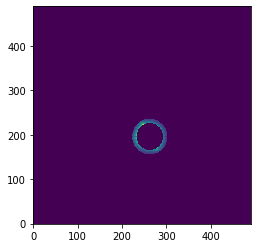

In [11]:
r_rings = np.array([0,10,20,30,40,50]) # 6 points, 5 bins

im_rings, r_radius = rings(pic1, xcen, ycen, r_rings)

# take mean, median and subtract off from 0 to 20 arcsec

r_mean = np.zeros_like(r_radius)
r_rms  = np.zeros_like(r_radius)

# copy ring 4 to blank image

im_test = np.zeros_like(pic1)
im_test[(im_rings == 3)] = pic1[(im_rings == 3)]

plt.imshow(im_test)

**Q5 (6 points):** Make a set of rings using `np.linspace()` with radii from 0 to 200. Vary the number of rings from 10 to 100, and then subtract off the `mean()` of each ring to produce an output image that you can examine with `ds9`.

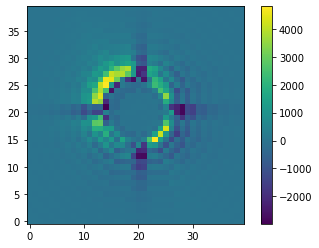

In [46]:
# Q5 answer here
ring_set = np.linspace(0,200,100)

im_rings, r_rad = rings(pic1, xcen, ycen, ring_set)

##Test
# plt.imshow(im_rings)


im_empty = np.zeros_like(pic1)

for i in range(len(ring_set)):
    im_empty[(im_rings == i)] = np.nanmedian(pic1[im_rings == i])

bd = pic1 - im_empty
   
plt.imshow(zoom(bd,xcen,ycen,20))
plt.colorbar()


# END Q5 answer

filename = 'pic_ringsubtract.fits'
hdu = fits.PrimaryHDU(bd)
hdu.writeto(filename, overwrite=True)


## Method 3: Subtract off a reference star

We load in another image of a nearby refence star with no disk around it, scale it and subtract it off. The exposure time of the reference star and its brightness may not be the same as that of beta Pictoris, so you will have to experiment to get the right scaling factor.


**Q6 (2 points):** Find the best scaling factor, according to your best judgement.

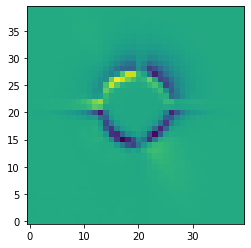

In [34]:
# Q6 answer here

exp_t_ref1 = ref1_header['EXPOSURE'] * ref1_header['NCOMBINE']
exp_t_pic1 = pic1_header['EXPOSURE'] * pic1_header['NCOMBINE']
scale = exp_t_pic1 / exp_t_ref1

pic_delt = pic1 - (1.7 * scale * ref1)
plt.imshow(zoom(pic_delt,xcen,ycen,20))



# END Q6 answer

filename = 'pic_refsub.fits'
hdu = fits.PrimaryHDU(pic_delt)
hdu.writeto(filename, overwrite=True)

## Displaying your best image of the Beta Pic disk

Display one of the three methods you have tested today, in a box that is about 200 pixels wide and set the image colour range from -5 to +10.

Rotate the image of beta Pictoris so that the disk is horiztontal, and label the plot in units of Astronomical Units. **HINT** look at the options for `imshow()` that include `extent` and `vmin` and `vmax`.

**Q7 (3 points):** What is the greatest extent of the disk in AU?

Are both sides of the disk the same size?

At what inner radius (in AU) would you *trust* the data? **HINT** where do the PSF removal residuals dominate?


398.52000725090807


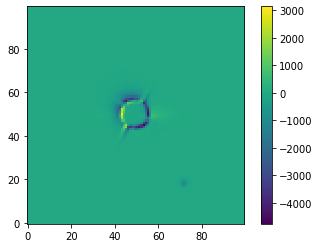

In [52]:
# North should be up, east left, pixel scale 0.41”/pix.
pscale = 0.41 # arcsec/pixel
dist = 19.44 # parsecs

#Rotate to match azimuth
pic_rotate = rotate2(pic_delt,-59.,np.array((ycen,xcen)))
pic_show = zoom(pic_rotate,xcen,ycen,50)

plt.imshow(pic_show)
plt.colorbar()

def convert_to_AU(pixels,pscale,dist):
    dist *= 206264.81 #PC to AU
    AUppix = dist*(np.pi / (3600.*180.))*pscale
    AU = AUppix * pixels
    return AU

print(convert_to_AU(50,pscale,dist))
#
#This seemed to be the greatest distance the halo went
#
# Q7 answers here

# END Q7 answers


Please put how many hours this practicum took you to complete in the cell below:

In [50]:
# Number of hours taken for this practicum:
#Far too long.  probably 6 hours
